# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_44', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_26', 'ORACLE.run2_32', 'ORACLE.run2_50', 'ORACLE.run2_38', 'ORACLE.run2_14'}


{'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_50'}


tensor([[[ 0.4766, -1.2546,  0.0000,  ...,  1.2741, -0.0875, -0.1751],
         [ 0.6905, -0.0584, -0.7781,  ..., -0.1653,  1.2157,  0.9239]],

        [[-1.0768,  0.0679,  1.3678,  ..., -0.4559, -0.8828,  0.9604],
         [-0.3298, -0.6596,  0.5141,  ...,  1.1738,  0.7954,  0.8731]],

        [[-1.1073, -0.5051,  1.0490,  ...,  0.5925,  0.2331,  1.1559],
         [ 0.6605, -0.7479, -0.7965,  ...,  1.3016,  0.8450, -0.1457]],

        ...,

        [[-0.6568,  0.4450,  0.7133,  ..., -0.1201, -1.1724, -0.9605],
         [ 0.0636, -1.1230,  0.4520,  ...,  1.1865, -0.5791, -0.2896]],

        [[ 0.2753, -1.1363,  0.0635,  ...,  1.1152,  0.4023,  0.7340],
         [ 0.6423,  0.4658, -1.0022,  ..., -0.5152,  1.3199,  0.5364]],

        [[-0.3049, -0.8297,  0.1773,  ...,  1.1772,  0.8864,  0.7659],
         [ 1.2410, -0.0284, -1.3828,  ...,  0.2766,  0.5248, -1.1204]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 31.0732, train_label_loss: 2.7889, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2325.3878, train_label_loss: 0.7924, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2308.6747, train_label_loss: 0.5772, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2287.0939, train_label_loss: 1.3805, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2344.4286, train_label_loss: 0.3809, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2638.2615, train_label_loss: 0.6284, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2599.3919, train_label_loss: 0.5316, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2569.1202, train_label_loss: 0.4816, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2582.2273, train_label_loss: 0.9202, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2620.2550, train_label_loss: 0.3657, 


epoch: 1, source_val_acc_label: 0.7781, target_val_acc_label: 0.7912, source_val_label_loss: 8.3007, target_val_label_loss: 4.6781, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.0753, train_label_loss: 0.6730, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2298.3149, train_label_loss: 0.7370, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2307.4984, train_label_loss: 0.6338, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2299.4739, train_label_loss: 0.6058, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2296.2419, train_label_loss: 0.5767, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2554.5376, train_label_loss: 0.3439, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2628.0808, train_label_loss: 0.6642, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2914.0789, train_label_loss: 0.4847, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2581.7918, train_label_loss: 0.3378, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2953.6364, train_label_loss: 0.8287, 


epoch: 2, source_val_acc_label: 0.8029, target_val_acc_label: 0.8125, source_val_label_loss: 0.5415, target_val_label_loss: 0.5197, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.2534, train_label_loss: 0.3510, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2598.4617, train_label_loss: 0.5065, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2702.9127, train_label_loss: 0.8106, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2713.4240, train_label_loss: 0.5087, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2992.4550, train_label_loss: 0.3567, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2591.9017, train_label_loss: 0.2205, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2766.1124, train_label_loss: 0.3038, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3003.1959, train_label_loss: 0.3348, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2690.5435, train_label_loss: 0.4171, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2568.7052, train_label_loss: 0.2522, 


epoch: 3, source_val_acc_label: 0.8365, target_val_acc_label: 0.8436, source_val_label_loss: 0.4694, target_val_label_loss: 0.4494, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.2786, train_label_loss: 0.4215, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2608.8261, train_label_loss: 0.5460, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2682.3994, train_label_loss: 0.6481, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2609.6575, train_label_loss: 0.1404, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2596.9698, train_label_loss: 0.7197, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3008.1064, train_label_loss: 0.8084, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3436.7340, train_label_loss: 0.2324, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3520.3675, train_label_loss: 0.2469, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3252.8804, train_label_loss: 0.1239, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3047.4693, train_label_loss: 0.2808, 


epoch: 4, source_val_acc_label: 0.8647, target_val_acc_label: 0.8567, source_val_label_loss: 0.3767, target_val_label_loss: 0.3971, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.4958, train_label_loss: 0.2169, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2303.8566, train_label_loss: 0.6394, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2289.3947, train_label_loss: 0.3004, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2303.2063, train_label_loss: 0.4665, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2299.7245, train_label_loss: 0.4792, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2349.6104, train_label_loss: 0.0920, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2564.3972, train_label_loss: 0.2679, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2651.1798, train_label_loss: 0.3604, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2599.6393, train_label_loss: 0.2453, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2793.5858, train_label_loss: 0.0450, 


epoch: 5, source_val_acc_label: 0.8731, target_val_acc_label: 0.8668, source_val_label_loss: 0.3519, target_val_label_loss: 0.3681, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.5533, train_label_loss: 1.2592, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2583.9560, train_label_loss: 0.2237, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2629.1886, train_label_loss: 0.2195, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2583.8710, train_label_loss: 0.4986, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2602.7770, train_label_loss: 0.0554, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2907.6461, train_label_loss: 0.2355, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3026.8167, train_label_loss: 0.2164, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2994.0033, train_label_loss: 0.3874, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3122.5495, train_label_loss: 0.8588, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3428.5169, train_label_loss: 0.4212, 


epoch: 6, source_val_acc_label: 0.8840, target_val_acc_label: 0.8749, source_val_label_loss: 0.3206, target_val_label_loss: 0.3582, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.9898, train_label_loss: 0.4777, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2909.0565, train_label_loss: 0.5264, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2691.7005, train_label_loss: 0.5397, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2316.2028, train_label_loss: 0.0616, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2362.5593, train_label_loss: 0.6692, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2597.6702, train_label_loss: 0.1477, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2608.5695, train_label_loss: 0.1644, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2556.8227, train_label_loss: 0.3427, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2833.8084, train_label_loss: 0.4137, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2894.6521, train_label_loss: 0.1876, 


epoch: 7, source_val_acc_label: 0.8858, target_val_acc_label: 0.8812, source_val_label_loss: 0.3076, target_val_label_loss: 0.3385, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.6194, train_label_loss: 0.0748, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2593.2968, train_label_loss: 0.2174, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2547.1031, train_label_loss: 0.1384, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2324.0087, train_label_loss: 0.2645, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2324.4313, train_label_loss: 0.0785, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2316.0059, train_label_loss: 0.1980, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2323.7428, train_label_loss: 0.2516, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2442.9207, train_label_loss: 0.1742, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2641.1796, train_label_loss: 0.0887, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2664.8728, train_label_loss: 0.0903, 


epoch: 8, source_val_acc_label: 0.8820, target_val_acc_label: 0.8664, source_val_label_loss: 0.3206, target_val_label_loss: 0.3739, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0547, train_label_loss: 0.5817, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2570.7001, train_label_loss: 0.1132, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2617.1588, train_label_loss: 0.2332, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2354.2504, train_label_loss: 0.2233, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2336.7029, train_label_loss: 0.3383, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2333.8266, train_label_loss: 0.6256, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2410.1224, train_label_loss: 0.2306, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2601.9669, train_label_loss: 0.1478, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2546.8625, train_label_loss: 0.2494, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2447.7148, train_label_loss: 0.0544, 


epoch: 9, source_val_acc_label: 0.8914, target_val_acc_label: 0.8770, source_val_label_loss: 0.2979, target_val_label_loss: 0.3590, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.0275, train_label_loss: 0.1867, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2585.1363, train_label_loss: 0.4458, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2649.1457, train_label_loss: 0.1136, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2310.9719, train_label_loss: 0.2251, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2326.5236, train_label_loss: 0.2413, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2384.2460, train_label_loss: 0.2826, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2609.4218, train_label_loss: 0.0206, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2564.2323, train_label_loss: 0.1762, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2532.8150, train_label_loss: 0.1460, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2301.3864, train_label_loss: 0.0587, 


epoch: 10, source_val_acc_label: 0.8936, target_val_acc_label: 0.8797, source_val_label_loss: 0.2947, target_val_label_loss: 0.3459, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.0362, train_label_loss: 0.0891, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2629.7701, train_label_loss: 0.1785, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2730.3040, train_label_loss: 0.1393, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2303.1192, train_label_loss: 0.1959, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2344.1080, train_label_loss: 0.5243, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2583.8338, train_label_loss: 0.5873, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2660.2263, train_label_loss: 0.1065, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2542.7352, train_label_loss: 0.4145, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2318.1416, train_label_loss: 0.2197, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2305.9921, train_label_loss: 0.0728, 


epoch: 11, source_val_acc_label: 0.8962, target_val_acc_label: 0.8831, source_val_label_loss: 0.2875, target_val_label_loss: 0.3427, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0729, train_label_loss: 0.3154, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2973.3104, train_label_loss: 0.1579, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3039.3592, train_label_loss: 0.0059, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2678.2482, train_label_loss: 0.1722, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2913.0557, train_label_loss: 0.0508, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3064.8121, train_label_loss: 0.3194, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2994.6012, train_label_loss: 0.2972, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2967.0502, train_label_loss: 0.1248, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2501.8803, train_label_loss: 0.1910, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2335.4525, train_label_loss: 0.4928, 


epoch: 12, source_val_acc_label: 0.8964, target_val_acc_label: 0.8820, source_val_label_loss: 0.2823, target_val_label_loss: 0.3463, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0104, train_label_loss: 0.0413, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2604.0305, train_label_loss: 0.2053, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2615.1756, train_label_loss: 0.0644, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2852.8668, train_label_loss: 0.1380, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2958.2388, train_label_loss: 0.1741, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2997.4125, train_label_loss: 0.1323, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2963.0099, train_label_loss: 0.1601, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2963.5887, train_label_loss: 0.2149, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2907.8315, train_label_loss: 0.3449, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2939.2253, train_label_loss: 0.3132, 


epoch: 13, source_val_acc_label: 0.8958, target_val_acc_label: 0.8833, source_val_label_loss: 0.3089, target_val_label_loss: 0.3488, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.7535, train_label_loss: 0.1897, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3696.5203, train_label_loss: 0.1224, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3946.3032, train_label_loss: 0.3496, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3951.8089, train_label_loss: 0.1355, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3900.4220, train_label_loss: 0.0431, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3866.3065, train_label_loss: 0.6066, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3827.3499, train_label_loss: 0.1242, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3798.6386, train_label_loss: 0.0423, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3492.2676, train_label_loss: 0.2155, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3034.1319, train_label_loss: 0.0800, 


epoch: 14, source_val_acc_label: 0.9013, target_val_acc_label: 0.8855, source_val_label_loss: 0.2802, target_val_label_loss: 0.3489, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.3813, train_label_loss: 0.1346, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2317.4487, train_label_loss: 0.1527, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2336.4660, train_label_loss: 0.1374, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2321.4716, train_label_loss: 0.2498, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2301.0832, train_label_loss: 0.3693, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2314.3132, train_label_loss: 0.0962, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2505.1448, train_label_loss: 0.1155, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2613.8036, train_label_loss: 0.1706, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2680.1156, train_label_loss: 0.1843, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2474.0554, train_label_loss: 0.2678, 


epoch: 15, source_val_acc_label: 0.8997, target_val_acc_label: 0.8831, source_val_label_loss: 0.2840, target_val_label_loss: 0.3528, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.1923, train_label_loss: 0.2783, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2323.8026, train_label_loss: 0.1126, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2283.2374, train_label_loss: 0.1801, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2321.6684, train_label_loss: 0.3001, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2312.6847, train_label_loss: 0.0648, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2311.7274, train_label_loss: 0.0847, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2459.3447, train_label_loss: 0.3191, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2699.7489, train_label_loss: 0.1442, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2971.3237, train_label_loss: 0.0814, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2920.6493, train_label_loss: 0.1572, 


epoch: 16, source_val_acc_label: 0.9009, target_val_acc_label: 0.8810, source_val_label_loss: 0.2751, target_val_label_loss: 0.3570, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.5334, train_label_loss: 0.1850, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2612.5606, train_label_loss: 0.0112, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2998.5473, train_label_loss: 0.1115, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2503.6034, train_label_loss: 0.6315, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2308.4228, train_label_loss: 0.0392, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2303.5898, train_label_loss: 0.0570, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2407.5115, train_label_loss: 0.2442, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2599.4650, train_label_loss: 0.0465, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2592.5306, train_label_loss: 0.0508, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2713.5411, train_label_loss: 0.0317, 


epoch: 17, source_val_acc_label: 0.9008, target_val_acc_label: 0.8834, source_val_label_loss: 0.2854, target_val_label_loss: 0.3577, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.2089, train_label_loss: 0.1366, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2317.1303, train_label_loss: 0.1374, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2313.1437, train_label_loss: 0.0244, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2330.0395, train_label_loss: 0.1885, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2305.2046, train_label_loss: 0.0061, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2312.5302, train_label_loss: 0.1466, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2358.5560, train_label_loss: 0.3962, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2627.4467, train_label_loss: 0.3556, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2648.8984, train_label_loss: 0.1032, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2864.6759, train_label_loss: 0.1360, 


epoch: 18, source_val_acc_label: 0.8996, target_val_acc_label: 0.8779, source_val_label_loss: 0.2864, target_val_label_loss: 0.3666, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

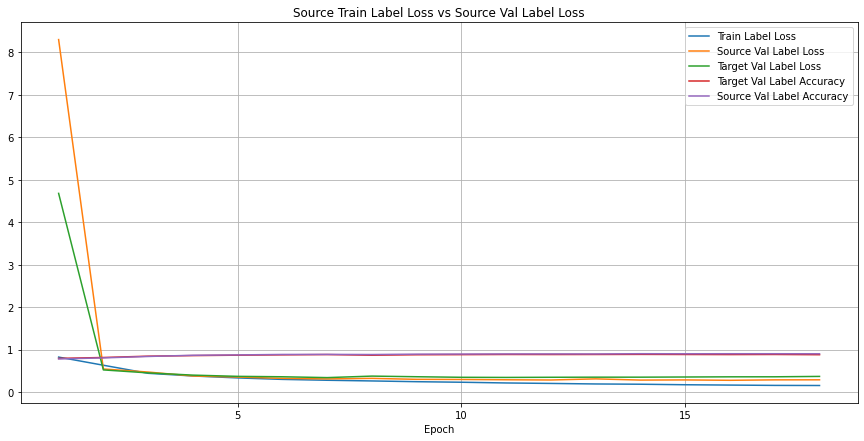

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

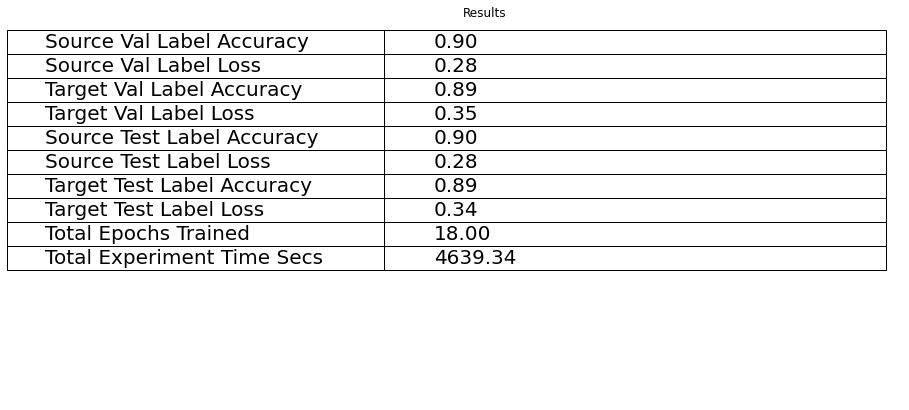

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

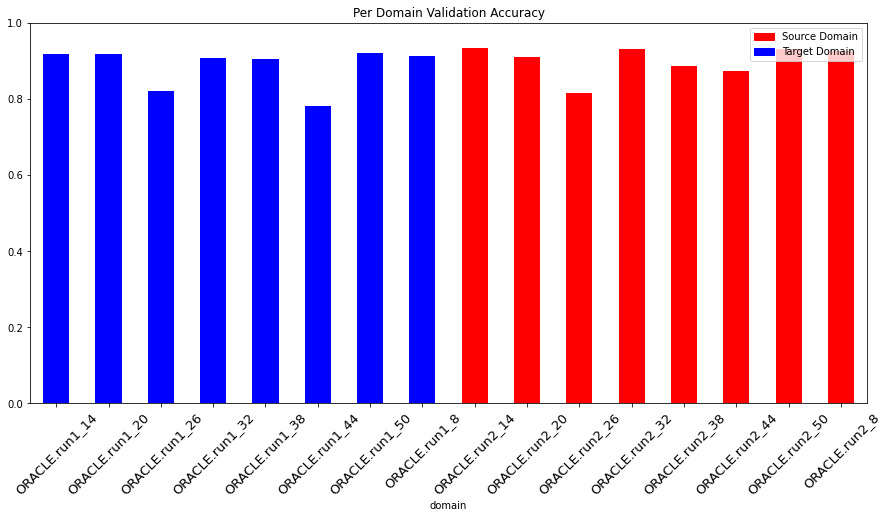

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9011067708333333 Target Test Label Accuracy: 0.8856770833333333
Source Val Label Accuracy: 0.90126953125 Target Val Label Accuracy: 0.8854817708333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048